# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from PIL import Image
import random
import re
from torch.utils.data import DataLoader, Dataset

In [2]:
!pip3 install deep_phonemizer

  Preparing metadata (setup.py) ... done
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33271 sha256=5631643359464bfb2f59316e3009a038a5a9b3508e04b786538944bbe1648ee1
  Stored in directory: /root/.cache/pip/wheels/c7/61/da/39b050eea5710fe32b1521b79de4a74d95896581230d30a37b
Successfully built deep_phonemizer


In [3]:
import IPython
import torchaudio

# **Device**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
epochs = 25

# **Setting Hyperparameters**

In [6]:
latent_dim = 128
features = 32
image_size = 224
in_channels = 3
learning_rate = 3e-4
batch_size =32
in_channels = 3
out_channels = 3
max_caption_length = 28
embedding_size = 256
text_embed_size = 50
hidden_size = 64

# **Defining Checkpointing**

In [7]:
def save_checkpoint(epoch, model, optimizer, t_loss, v_loss, root_dir):
    checkpoint = os.path.join(root_dir, 'checkpoint.pt')
    torch.save({
        'epoch' : epoch,
        't_loss' : t_loss,
        'v_loss' : v_loss,
        'model' : model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, checkpoint)
    print(f'Checkpoint Saved at epoch{epoch+1}')

def load_checkpoint(model, optimizer, root_dir):
    checkpoint = os.path.join(root_dir, 'checkpoint.pt')
    if os.path.exists(checkpoint):
        checkpoint_file = torch.load(checkpoint)
        epochs = checkpoint_file['epoch']
        t_loss = checkpoint_file['t_loss']
        v_loss = checkpoint_file['v_loss']
        model = model.load_state_dict(checkpoint_file['model'])
        optimizer = optimizer.load_state_dict(checkpoint_file['optimizer'])
        return epochs + 1, loss
    
    else:
        return 0, [], []

In [8]:
def lower_case(text):
    l = []
    for i in text.split():
        l.append(i.lower())

    return " ".join(l)


def remove_numbers_punctuation_special(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and special symbols
    text = re.sub(r'[^\w\s]', '', text)
    return text

# **Custom Dataset**

In [9]:
class ImagesToCaptionDataset(Dataset):
    def __init__(self, caption_path, images_path, max_caption_length, transform=None):
        super().__init__()
        self.images_path = images_path
        self.data = pd.read_csv(caption_path)
        self.images = self.data['image']
        self.captions = self.data['caption']
        self.captions = self.captions.apply(lower_case)
        self.captions = self.captions.apply(remove_numbers_punctuation_special)
        self.transform = transform
        self.max_length = max_caption_length - 2
        self.vocabulary = self.get_vocabulary()
        self.vocab_size = len(self.vocabulary)

    def get_vocabulary(self):
        vocab = {'<sos>': 0, '<pad>': 1, '<eos>': 2}
        idx = 3
        for i in self.captions:
            for j in i.split():
                if j not in vocab:
                    vocab[j] = idx
                    idx += 1
        return vocab

    def prepare_sequence(self, seq):
        idxs = [0]
        idxs += [self.vocabulary[w] for w in seq]
        idxs += [2]

        if len(idxs) < self.max_length + 2:
            idxs += [1] * (self.max_length + 2 - len(idxs))

        else:
            idxs = idxs[:self.max_length+2]

        return idxs

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_name = self.images[index]
        image = Image.open(os.path.join(self.images_path, image_name)).convert('RGB')
        caption = self.captions[index]
        caption = self.prepare_sequence(caption.split())

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(caption, dtype=torch.long)

In [10]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

dataset = ImagesToCaptionDataset('/kaggle/input/flickr8k/captions.txt', '/kaggle/input/flickr8k/Images', max_caption_length,
                                 transform)
vocabulary_size = dataset.vocab_size
caption_vocab = dataset.vocabulary

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1])

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True)



# **VAE as Encoder-CNN**

In [11]:
class Encoder(nn.Module):
    def __init__(self, in_channels, features):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            self.block(features, features*2, 3, 2, 1),
            self.block(features*2, features*4 ,3,2,1),
            self.block(features*4, features*8, 3, 2, 1),
            nn.Conv2d(features*8, features*16, 3, 2, 1),
            nn.Sigmoid()
        )
        
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return self.layer
    
    def forward(self, x):
        x = self.encode(x)
        return x

In [12]:
class Decoder(nn.Module):
    def __init__(self, out_channels, features):
        super().__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(features*16, features*8,2,2,0),
            nn.ReLU(),
            self.block(features*8, features*4,2,2,0),
            self.block(features*4, features*2,2,2,0),
            self.block(features*2, features,2,2,0),
            nn.ConvTranspose2d(features, out_channels,2,2,0),
            nn.Sigmoid()
        )
        
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return self.layer
    
    def forward(self, x):
        x = self.decode(x)
        return x

In [13]:
class ImageEmbedding(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super().__init__()
        self.encoder = Encoder(in_channels, features)
        self.decoder = Decoder(out_channels, features)
        self.mu = nn.Linear((features*16)*(image_size//32)*(image_size//32), latent_dim)
        self.logvar = nn.Linear((features*16)*(image_size//32)*(image_size//32), latent_dim)
        self.fc = nn.Linear(latent_dim, (features*16)*(image_size//32)*(image_size//32))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mu, logvar)
        z1 = self.fc(z)
        z1 = z1.view(z1.size(0), (features*16),(image_size//32),(image_size//32))
        z1 = self.decoder(z1)
        return z1, mu, logvar, z

# **ELBO Loss**

In [14]:
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [14]:
checkpoint_dir_vae = '/kaggle/working/checkpoints_vae'
os.makedirs(checkpoint_dir_vae, exist_ok=True)

# **Training the VAE encoder**

In [16]:
model = ImageEmbedding(in_channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = vae_loss

start_epoch, train_loss, v_loss = load_checkpoint(model, optimizer, checkpoint_dir_vae)
best_val_loss = float("inf")
for epoch in range(epochs):
    model.train()
    t_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        recon_batch, mu, logvar, _ = model(data)
        loss = criterion(recon_batch, data, mu, logvar)
        loss.backward()
        t_loss += loss.item()
        optimizer.step()
    t_loss /= len(train_loader.dataset)
    train_loss.append(t_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            recon_batch, mu, logvar, _ = model(data)
            valid_loss = criterion(recon_batch, data, mu, logvar)
            val_loss += valid_loss.item()
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f"/kaggle/working/checkpoints_vae/model.pth")
            
        val_loss = val_loss/len(val_loader)
        v_loss.append(val_loss)
        
    print(f'Epoch {epoch+1}, Train Loss: {t_loss}')
    print(f'Epoch {epoch+1}, Val Loss: {val_loss}')
    save_checkpoint(epoch, model, optimizer, train_loss, val_loss, checkpoint_dir_vae)

Epoch 1, Train Loss: 4973.658392168244
Epoch 1, Val Loss: 406689.24413290515
Checkpoint Saved at epoch1
Epoch 2, Train Loss: 3539.792692737208
Epoch 2, Val Loss: 375752.19361413043
Checkpoint Saved at epoch2
Epoch 3, Train Loss: 3095.8500363603057
Epoch 3, Val Loss: 315038.7874567688
Checkpoint Saved at epoch3
Epoch 4, Train Loss: 2857.237378725414
Epoch 4, Val Loss: 303504.5580533597
Checkpoint Saved at epoch4
Epoch 5, Train Loss: 2765.9772036331615
Epoch 5, Val Loss: 299716.76367959485
Checkpoint Saved at epoch5
Epoch 7, Train Loss: 2596.4823680104346
Epoch 7, Val Loss: 276640.8664000741
Checkpoint Saved at epoch7
Epoch 8, Train Loss: 2521.702499453768
Epoch 8, Val Loss: 267642.4257966897
Checkpoint Saved at epoch8
Epoch 9, Train Loss: 2437.998668076203
Epoch 9, Val Loss: 262961.4886672431
Checkpoint Saved at epoch9
Epoch 10, Train Loss: 2387.935241550505
Epoch 10, Val Loss: 258597.53021553854
Checkpoint Saved at epoch10
Epoch 11, Train Loss: 2337.559406891133
Epoch 11, Val Loss: 249

In [15]:
model = ImageEmbedding(in_channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = vae_loss
model.load_state_dict(torch.load("/kaggle/input/checkpoints-vae/model.pth"))

<All keys matched successfully>

# **Loss vs Epoch Curves**

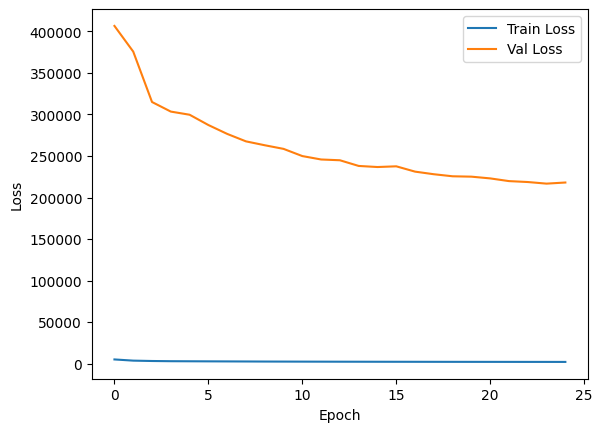

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.plot(v_loss, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# **Checking Reconstruction to ensure functioning**

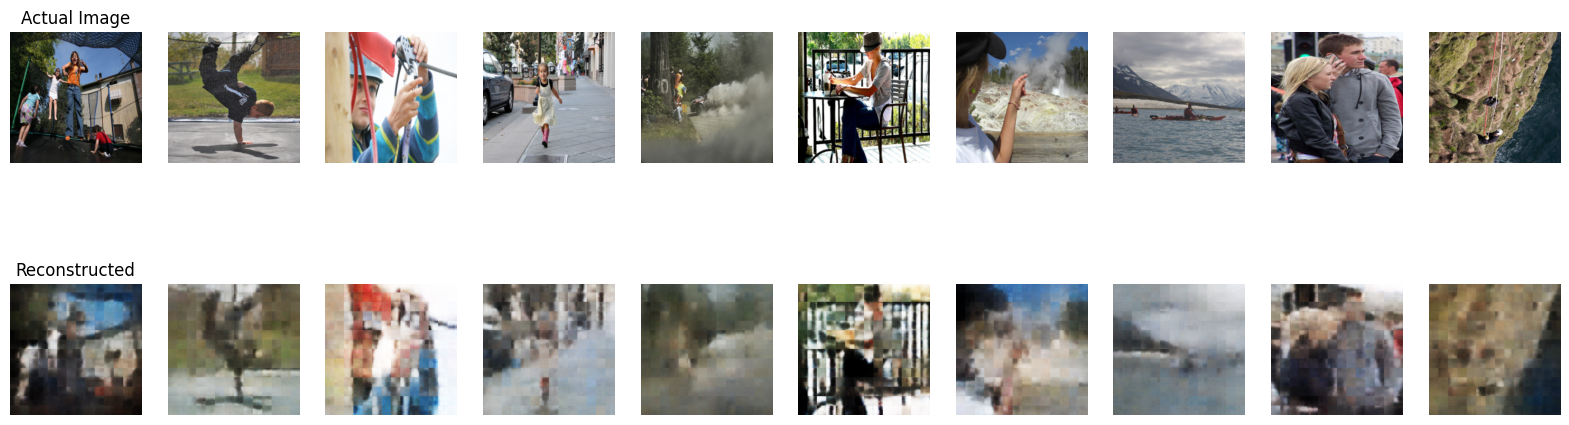

In [16]:
test_batch = next(iter(test_loader))[0].to(device)

model.eval()
recon_batch_vae, _, _,_ = model(test_batch)

fig, ax = plt.subplots(2, 10, figsize=(20, 6))
ax[0, 0].set_title("Actual Image")
ax[1, 0].set_title("Reconstructed")
for i in range(10):
    ax[0, i].imshow(test_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[1, i].imshow(recon_batch_vae[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[0, i].axis('off')
    ax[1, i].axis('off')
plt.show()

# **Decoder of Image Captioner**

In [16]:
class TextEmbedding(nn.Module):
    def __init__(self, embedding_size, vocab_size, hidden_size):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(0.2)
        self.lstm1 = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=2*hidden_size)

    def forward(self, x):
        embeddings = self.embeddings(x)
        embeddings = self.dropout(embeddings)
        outs1, _ = self.lstm1(embeddings)
        outs1 = self.dropout(outs1)
        outs2, _ = self.lstm2(outs1)
        return outs2

# **Complete Model**

In [18]:
class ImageCaptioner(nn.Module):
    def __init__(self, latent_model, text_embed_size, vocab_size, hidden_size):
        super().__init__()
        
        self.latent_model = latent_model
        self.text_embeddings = TextEmbedding(text_embed_size, vocab_size, hidden_size)
        self.words = nn.Sequential(
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.Linear(2*hidden_size, vocab_size)
        )

    def forward(self, image, captions):
        _,_,_,latent_embeddings = self.latent_model(image)
        text_embeddings = self.text_embeddings(captions)
#         print(latent_embeddings.shape, text_embeddings.shape)
        latent_embeddings = latent_embeddings.unsqueeze(1).expand_as(text_embeddings)
        total_embeddings = torch.add(latent_embeddings, text_embeddings)
        return self.words(total_embeddings)

In [19]:
checkpoint_dir_IC = '/kaggle/working/checkpoints_IC'
os.makedirs(checkpoint_dir_IC, exist_ok=True)

# **Training the complete Model**

In [23]:
model_IC = ImageCaptioner(model, text_embed_size, vocabulary_size, hidden_size).to(device)
optimizer_IC = optim.Adam(model_IC.parameters(), lr = learning_rate)
criterion_IC = nn.CrossEntropyLoss(ignore_index = caption_vocab['<pad>'])

start_epoch, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_dir_IC)
best_val_loss = float("inf")
for epoch in range(epochs):
    model_IC.train()
    t_loss = 0
    for batch_idx, (images, captions) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        captions = captions.to(device)
        outputs = model_IC(images, captions[:, :-1])
        
        captions = captions[:, 1:].reshape(-1)
        loss = criterion_IC(outputs.reshape(-1, vocabulary_size), captions)
        loss.backward()
        t_loss += loss.item()
        optimizer.step()
    t_loss /= len(train_loader.dataset)
    train_losses.append(t_loss)
    
    model_IC.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, captions) in enumerate(train_loader):
            images = images.to(device)
            captions = captions.to(device)
            outputs = model_IC(images, captions[:, :-1])
            captions = captions[:, 1:].reshape(-1)
            valid_loss = criterion_IC(outputs.reshape(-1, vocabulary_size), captions)
            val_loss += valid_loss.item()
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model_IC.state_dict(), f"/kaggle/working/checkpoints_IC/model_IC.pth")
            
        val_loss = val_loss/len(val_loader)
        val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {t_loss}')
    print(f'Epoch {epoch+1}, Val Loss: {val_loss}')
    save_checkpoint(epoch, model, optimizer, train_losses, val_losses, checkpoint_dir_IC)

Epoch 1, Train Loss: 0.24853514306579522
Epoch 1, Val Loss: 27.374847971874736
Checkpoint Saved at epoch1
Epoch 2, Train Loss: 0.24376017574435713
Epoch 2, Val Loss: 27.175260988619957
Checkpoint Saved at epoch2
Epoch 3, Train Loss: 0.2414206406790564
Epoch 3, Val Loss: 26.762308535368547
Checkpoint Saved at epoch3
Epoch 4, Train Loss: 0.23888339772054867
Epoch 4, Val Loss: 26.45157070499164
Checkpoint Saved at epoch4
Epoch 5, Train Loss: 0.23625585572262167
Epoch 5, Val Loss: 26.216730283654254
Checkpoint Saved at epoch5


# **Loss vs Epoch Curves**

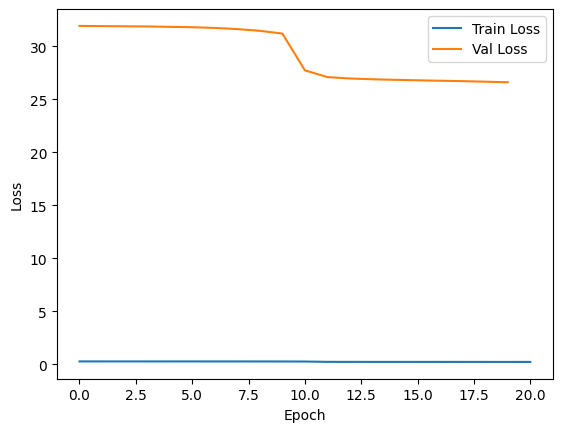

In [23]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# **Generating Captions**

In [22]:
reversed_vocab = {value: key for key, value in caption_vocab.items()}

In [23]:
def get_real_captions(reversed_vocab, batch_tensors):
    sentences = []
    for tensor in batch_tensors:
        # Map each number in the tensor to its corresponding word using the reversed dictionary
        words = [reversed_vocab[int(number)] for number in tensor]
        # Join the words to form sentences
        sentence = ' '.join(filter(None, words))  # filter(None, ...) removes None values from the list
        sentences.append(sentence)

    return sentences

In [24]:
def pad_sequence(sequence, max_length, vocab):
    if len(sequence) < max_length:
        sequence += [vocab['<pad>']] * (max_length - len(sequence))

    return sequence

In [25]:
def generate_caption(model, image, max_length=20):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        # Initialize the caption with start token
        caption = [caption_vocab['<sos>']]
        for _ in range(max_length):
            # Convert the current caption to tensor
            caption_tensor = torch.tensor([caption]).to(device)
            # Generate output for the current caption
            output = model(image, caption_tensor).argmax(2)
            # Get the last word predicted
            last_word = output[0][-1].item()
            # Append the word to the caption
            caption.append(last_word)
            # If end token is predicted, stop generating
            if last_word == caption_vocab['<eos>']:
                break
    # Convert the caption from indices to words
    generated_caption = ' '.join([reversed_vocab[word] for word in caption[1:-1]])
    return generated_caption


# **Text to Audio**

In [26]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

100%|██████████| 63.6M/63.6M [00:03<00:00, 21.8MB/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth
100%|██████████| 107M/107M [00:00<00:00, 217MB/s]  
Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth
100%|██████████| 16.7M/16.7M [00:00<00:00, 85.8MB/s]


In [27]:
def text2speech(input_text):
    with torch.inference_mode():
        processed, lengths = processor(input_text)
        processed = processed.to(device)
        lengths = lengths.to(device)
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        waveforms, lengths = vocoder(spec, spec_lengths)

    return IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)

# **Checking Outputs**

In [40]:
# Choose a single image and caption from the test_loader
image, caption = next(iter(test_loader))
image = image[0].unsqueeze(0).to(device)  # Choose the first image from the batch
caption = caption[0].unsqueeze(0).to(device)  # Choose the corresponding caption

print("Real Caption:", get_real_captions(reversed_vocab, caption))
print()
real_caption = get_real_captions(reversed_vocab, caption)

Real Caption: ['<sos> a black dog on a beach carrying a ball in its mouth <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']



In [41]:
# Generate caption for the chosen image
generated_caption = generate_caption(model_IC, image)
print("Generated Caption:", generated_caption)

Generated Caption: dog in black in black in black the ball the ball ball


In [42]:
audio = text2speech(generated_caption)

In [43]:
audio